<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/12_run_balanced_bagged_rf_with_tqdm_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Prediction – Run models separately (per-cell)

**แนวคิด:** รันแต่ละโมเดลแยก cell เพื่อช่วยดีบัก/ควบคุมหน่วยความจำได้ง่ายขึ้น และใช้ **train/test split ร่วมกัน**

ลำดับรันแนะนำ:
1) Load `df` (หรือข้ามถ้าคุณมี `df` อยู่แล้ว)
2) Feature selection (X,y) + map target (alive→0, failed→1)
3) Import & class definitions
4) สร้าง Controller
5) **Split & Share** (เตรียม `shared_split`)
6) รันแต่ละโมเดล (LogReg / DT / RF / NB / SVM / Perceptron / MLP / PCA+RF / PCA+SVM / KMeans / Agglo)
7) Benchmark table, ROC curves, Loss curve


In [1]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')


In [5]:
# import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'american-companies-bankruptcy-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/american-companies-bankruptcy-prediction-dataset


In [6]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = "/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv"

df = pd.read_csv(file_path)

print("Loaded shape:", df.shape)
print("Columns:\n", list(df.columns))
df.head()

Loaded shape: (78682, 21)
Columns:
 ['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [8]:

# FEATURES_OLD = ["X8","X17","X3","X11","X10","X1","X6"]
FEATURES = ["X1","X2","X3","X4","X5","X6","X7","X8","X9","X11","X12","X13","X14","X15","X16","X17","X18","year"]
TARGET   = "status_label"
COMPANY  = "company_name"   # ถ้าไม่มีคอลัมน์นี้ โค้ดจะ fallback อัตโนมัติ


In [11]:

# 0) ตรวจว่าคอลัมน์ครบไหม
missing = [c for c in FEATURES+[TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns: {missing}")

# 1) ฟังก์ชัน normalize label ให้เป็น 0/1 แบบทนทาน
def normalize_status(x):
    if pd.isna(x):
        return np.nan
    t = str(x).strip().lower()
    # ตัวเลขที่มาเป็นสตริง หรือ float 0.0/1.0
    if t in {"0","1"}:
        return int(t)
    try:
        # กรณีเป็น 0.0/1.0 จริง ๆ
        f = float(t)
        if f in (0.0, 1.0):
            return int(f)
    except:
        pass
    # แม็พคำยอดฮิต
    direct = {
        "alive": 0, "non-bankrupt": 0, "nonbankrupt": 0, "healthy": 0, "normal": 0,
        "failed": 1, "fail": 1, "bankrupt": 1, "bankruptcy": 1, "went_bankrupt": 1,
        "yes": 1, "y": 1, "true": 1,
        "no": 0, "n": 0, "false": 0
    }
    if t in direct:
        return direct[t]
    # สุดท้าย ถ้าระบุไม่ถูก ให้คืน NaN เพื่อตรวจสอบ
    return np.nan

y_norm = df[TARGET].apply(normalize_status)

# 2) เช็คค่าที่แปลงไม่ได้ (จะเป็น NaN)
bad_mask = y_norm.isna()
if bad_mask.any():
    print("⚠️ พบ label ที่ไม่รู้จัก (ตัวอย่าง top 20):")
    print(df.loc[bad_mask, TARGET].value_counts().head(20))
    # ทางเลือก: ตัดแถวที่ label ไม่ชัดเจนทิ้งไปก่อน
    df = df.loc[~bad_mask].copy()
    y_norm = y_norm.loc[~bad_mask]

# 3) เขียนกลับเป็นตัวเลข 0/1
df[TARGET] = y_norm.astype(int)

In [12]:
# ==============================
# Load your DataFrame (df)
# ==============================
try:
    df  # noqa: F821
    print("✅ Found existing `df`.")
except NameError:
    import pandas as pd
    print("ℹ️ No existing `df` found. Creating a tiny placeholder. Replace with your CSV load.")
    df = pd.DataFrame({
        "X8":[0.1,0.2,0.3,0.4],
        "X17":[1,2,3,4],
        "X3":[5,6,7,8],
        "X11":[0,1,0,1],
        "X15":[10,11,12,13],
        "X1":[2,3,4,5],
        "X6":[9,8,7,6],
        "status_label":["alive","failed","alive","failed"],
    })
print("df shape:", df.shape)


✅ Found existing `df`.
df shape: (78682, 21)


In [13]:
# ==============================
# Feature selection (X, y) + map target
# ==============================
import numpy as np
import pandas as pd

FEATURES = FEATURES
TARGET   = "status_label"

missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns in df: {missing}")

# Make sure the target column is integer type
df[TARGET] = df[TARGET].astype(int)

X = df[FEATURES].copy()
y = df[TARGET].copy()

print("✅ X,y ready.")
print("X shape:", X.shape, "| y counts:", dict(pd.Series(y).value_counts()))

✅ X,y ready.
X shape: (78682, 18) | y counts: {0: np.int64(73462), 1: np.int64(5220)}


In [14]:
# ==============================
# Imports
# ==============================
!pip -q install imbalanced-learn
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, f1_score,
    precision_score, recall_score, roc_curve, auc
)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import accuracy_score, classification_report

plt.style.use("ggplot")
RANDOM_STATE = 42


In [15]:
# ==============================
# Imports
# ==============================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, f1_score,
    precision_score, recall_score, roc_curve, auc
)

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

from imblearn.ensemble import BalancedBaggingClassifier

plt.style.use("ggplot")
RANDOM_STATE = 42


# ==============================
# Base & Subclass Models (OOP)
# ==============================
class BaseModel(ABC):
    def __init__(self, X: pd.DataFrame, y: pd.Series, model_params: dict = None, random_state: int = RANDOM_STATE):
        self.X = X
        self.y = y
        self.random_state = random_state
        self.model = None
        self.model_params = model_params if model_params is not None else {}
        self.X_train = None
        self.X_test  = None
        self.y_train = None
        self.y_test  = None
        self.scaler = StandardScaler()
        self.history = None
        self.is_fitted = False

    def split_data(self, test_size: float = 0.2, scale: bool = True):
        X_train_raw, X_test_raw, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=self.random_state, stratify=self.y
        )
        if scale:
            self.X_train = pd.DataFrame(self.scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
            self.X_test  = pd.DataFrame(self.scaler.transform(X_test_raw), columns=X_test_raw.columns)
        else:
            self.X_train = X_train_raw
            self.X_test  = X_test_raw

    @abstractmethod
    def build_model(self):
        pass

    # ✅ Generic Balanced Bagging wrapper usable by any subclass
    def BagBalanced(self, input_model, **bag_kwargs):
        """
        Wrap any sklearn estimator (or Pipeline) with BalancedBaggingClassifier.
        """
        defaults = dict(
            estimator=input_model,      # IMPORTANT: use 'estimator' kwarg
            sampling_strategy="auto",
            replacement=False,
            bootstrap=True,
            n_jobs=-1,
            random_state=self.random_state,
        )
        defaults.update(bag_kwargs or {})
        return BalancedBaggingClassifier(**defaults)

    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split. Call .split_data() first.")
        self.build_model()
        self.model.fit(self.X_train, self.y_train)
        self.is_fitted = True
        if hasattr(self.model, "loss_curve_"):
            self.history = {"loss_curve": self.model.loss_curve_}
        print(f"✅ {self.__class__.__name__} trained.")

    def evaluate(self):
        if isinstance(self.model, (KMeans, AgglomerativeClustering)):
            return {"Note": "Unsupervised Model: Use specific clustering metrics."}

        if self.y_test is None or not self.is_fitted:
            return {"Error": "Model not fitted or Test data not available."}

        y_pred = self.model.predict(self.X_test)
        results = {}
        if len(np.unique(self.y_test)) == 2:
            try:
                tn, fp, fn, tp = confusion_matrix(self.y_test, y_pred).ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) else 0.0
                specificity = tn / (tn + fp) if (tn + fp) else 0.0
                results = {
                    "Loss (MLP only)": getattr(self.model, "loss_", "N/A"),
                    "Confusion Matrix": confusion_matrix(self.y_test, y_pred).tolist(),
                    "Accuracy": accuracy_score(self.y_test, y_pred),
                    "Precision": precision_score(self.y_test, y_pred, zero_division=0),
                    "Sensitivity (Recall)": sensitivity,
                    "Specificity (TNR)": specificity,
                    "F1-score": f1_score(self.y_test, y_pred, zero_division=0),
                    "ROC AUC": "N/A",
                }
                if hasattr(self.model, "predict_proba"):
                    y_proba = self.model.predict_proba(self.X_test)[:, 1]
                    results["ROC AUC"] = roc_auc_score(self.y_test, y_proba)
            except Exception as e:
                results = {"Error": f"Evaluation failed: {e}"}
        else:
            results = {"Accuracy": accuracy_score(self.y_test, y_pred)}
        return results

    def plot_roc(self, ax=None, label_prefix=""):
        if not hasattr(self.model, "predict_proba") or self.y_test is None:
            return
        y_proba = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        ax.plot(fpr, tpr, label=f"{label_prefix} (AUC = {roc_auc:.4f})")
        ax.plot([0, 1], [0, 1], "r--")

    def plot_performance_curve(self, ax=None, label_prefix=""):
        if hasattr(self.model, "loss_curve_") and self.model.loss_curve_ is not None:
            if ax is None:
                fig, ax = plt.subplots(1, 1)
            ax.plot(self.model.loss_curve_, label=f"{label_prefix} Loss")
            ax.set_title("Model Loss Curve")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.legend()


# ===== Concrete single-model subclasses =====
class LogisticRegressionModel(BaseModel):
    def build_model(self):
        self.model = LogisticRegression(random_state=self.random_state, **self.model_params)

class DecisionTreeModel(BaseModel):
    def build_model(self):
        self.model = DecisionTreeClassifier(random_state=self.random_state, **self.model_params)

class RandomForestModel(BaseModel):
    def build_model(self):
        self.model = RandomForestClassifier(random_state=self.random_state, **self.model_params)

class NaiveBayesModel(BaseModel):
    def build_model(self):
        self.model = GaussianNB(**self.model_params)

class SupportVectorMachineModel(BaseModel):
    def build_model(self):
        self.model = SVC(random_state=self.random_state, probability=True, **self.model_params)

class PerceptronModel(BaseModel):
    def build_model(self):
        self.model = Perceptron(random_state=self.random_state, **self.model_params)

class MLPModel(BaseModel):
    def build_model(self):
        self.model = MLPClassifier(random_state=self.random_state, **self.model_params)

class KMeanClustering(BaseModel):
    def build_model(self):
        n_clusters = self.model_params.pop("n_clusters", 2)
        self.model = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=10, **self.model_params)
    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split.")
        self.build_model()
        self.model.fit(self.X_train)
        self.is_fitted = True
        print(f"✅ {self.__class__.__name__} trained.")

class AgglomerativeClusteringModel(BaseModel):
    def build_model(self):
        n_clusters = self.model_params.pop("n_clusters", 2)
        self.model = AgglomerativeClustering(n_clusters=n_clusters, **self.model_params)
    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split.")
        self.build_model()
        self.model.fit(self.X_train)
        self.is_fitted = True
        print(f"✅ {self.__class__.__name__} trained.")

class ReducedClassifierModel(BaseModel):
    def __init__(self, X, y, classifier_class, n_components, model_params=None, random_state=RANDOM_STATE):
        super().__init__(X, y, model_params, random_state)
        self.classifier_class = classifier_class
        self.n_components = n_components
    def build_model(self):
        pca = PCA(n_components=self.n_components, random_state=self.random_state)
        if self.classifier_class == SVC:
            classifier = SVC(random_state=self.random_state, probability=True, **self.model_params)
        else:
            classifier = self.classifier_class(random_state=self.random_state, **self.model_params)
        self.model = Pipeline(steps=[("pca", pca), ("classifier", classifier)])


# ==============================
# Generic Balanced-Bagging model (works for any base estimator/pipeline)
# ==============================
class BalancedBaggingModel(BaseModel):
    """
    A generic model that bags ANY base estimator using BalancedBaggingClassifier.
    Pass a factory that builds the base estimator given (random_state, **params).
    """
    def __init__(self, X, y, base_model_factory, bag_params=None,
                 model_params=None, random_state=RANDOM_STATE):
        super().__init__(X, y, model_params, random_state)
        self.base_model_factory = base_model_factory
        self.bag_params = bag_params or {}

    def build_model(self):
        base_estimator = self.base_model_factory(self.random_state, **self.model_params)
        self.model = self.BagBalanced(base_estimator, **self.bag_params)


# ==============================
# Base-estimator factories (reusable)
# ==============================
def rf_factory(rs, **p):
    return RandomForestClassifier(random_state=rs, **p)

def dt_factory(rs, **p):
    return DecisionTreeClassifier(random_state=rs, **p)

def svm_factory(rs, **p):
    p = {"probability": True, **p}
    return SVC(random_state=rs, **p)

def logreg_factory(rs, **p):
    return LogisticRegression(random_state=rs, **p)

def mlp_factory(rs, **p):
    return MLPClassifier(random_state=rs, **p)

def pca_then_factory(clf_class, n_components=5):
    """
    Returns a factory that builds Pipeline(PCA -> classifier).
    p['pca_n'] can override n_components at call time.
    """
    def _factory(rs, **p):
        pca_n = p.pop("pca_n", n_components)
        if clf_class is SVC:
            p = {"probability": True, **p}
        clf = clf_class(random_state=rs, **p)
        return Pipeline([
            ("pca", PCA(n_components=pca_n, random_state=rs)),
            ("classifier", clf),
        ])
    return _factory


# ==============================
# Controller (no run_all)
# ==============================
class ModelController:
    def __init__(self, X: pd.DataFrame, y: pd.Series, test_size: float = 0.2, random_state: int = RANDOM_STATE):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.models = self._initialize_models()
        self.results = {}

    def _initialize_models(self):
        svm_params  = {"C": 10, "gamma": "auto", "class_weight": "balanced"}
        rf_params   = {"n_estimators": 150, "class_weight": "balanced_subsample"}
        lr_params   = {"class_weight": "balanced"}
        dt_params   = {"class_weight": "balanced"}
        perc_params = {"class_weight": "balanced"}
        mlp_params  = {"hidden_layer_sizes": (50,), "max_iter": 500}

        # Shared balanced-bagging params (number of bagged base estimators, etc.)
        bag_params = {"n_estimators": 100}  # adjust as you like

        return {
            # Originals
            "Logistic Regression": LogisticRegressionModel(self.X, self.y, model_params=lr_params),
            "Decision Tree": DecisionTreeModel(self.X, self.y, model_params=dt_params),
            "Random Forest": RandomForestModel(self.X, self.y, model_params=rf_params),
            "Naïve Bayesian": NaiveBayesModel(self.X, self.y),
            "Support Vector Machine": SupportVectorMachineModel(self.X, self.y, model_params=svm_params),
            "Perceptron (SLP)": PerceptronModel(self.X, self.y, model_params=perc_params),
            "Multi-layer Perceptron (MLP)": MLPModel(self.X, self.y, model_params=mlp_params),
            "PCA(5) + RF": ReducedClassifierModel(self.X, self.y, RandomForestClassifier, n_components=5, model_params=rf_params),
            "PCA(5) + SVM": ReducedClassifierModel(self.X, self.y, SVC, n_components=5, model_params=svm_params),
            "K-Means Clustering (k=2)": KMeanClustering(self.X, self.y, model_params={"n_clusters": 2}),
            "Agglomerative Clustering (k=2)": AgglomerativeClusteringModel(self.X, self.y, model_params={"n_clusters": 2}),

            # ✅ Balanced-bagging variants (plug & play)
            "Bagged (Balanced) RF": BalancedBaggingModel(
                self.X, self.y, base_model_factory=rf_factory,
                bag_params=bag_params,
                model_params={"n_estimators": 150, "class_weight": None}  # let bagging handle balance
            ),
            "Bagged (Balanced) DT": BalancedBaggingModel(
                self.X, self.y, base_model_factory=dt_factory,
                bag_params=bag_params,
                model_params={}
            ),
            "Bagged (Balanced) SVM": BalancedBaggingModel(
                self.X, self.y, base_model_factory=svm_factory,
                bag_params=bag_params,
                model_params={"C": 10, "gamma": "auto", "class_weight": "balanced"}
            ),
            "Bagged (Balanced) MLP": BalancedBaggingModel(
                self.X, self.y, base_model_factory=mlp_factory,
                bag_params=bag_params,
                model_params={"hidden_layer_sizes": (50,), "max_iter": 500}
            ),
            "Bagged (Balanced) PCA(5)+RF": BalancedBaggingModel(
                self.X, self.y, base_model_factory=pca_then_factory(RandomForestClassifier, n_components=5),
                bag_params=bag_params,
                model_params={"n_estimators": 150, "class_weight": None}
            ),
            "Bagged (Balanced) PCA(5)+SVM": BalancedBaggingModel(
                self.X, self.y, base_model_factory=pca_then_factory(SVC, n_components=5),
                bag_params=bag_params,
                model_params={"C": 10, "gamma": "auto", "class_weight": "balanced"}
            ),
        }

    def get_results(self, model_name: str = None):
        if model_name:
            return self.results.get(model_name, "Model not found or not run.")
        return self.results

    def show_benchmarking(self):
        classification = {k: v for k, v in self.results.items()
                          if isinstance(v, dict) and ('Accuracy' in v or 'ROC AUC' in v)}
        if not classification:
            print("\n⚠️ No classification results to show benchmarking.")
            return
        df_results = pd.DataFrame.from_dict(classification, orient="index")
        metrics_order = ["Accuracy", "ROC AUC", "F1-score", "Precision", "Sensitivity (Recall)", "Specificity (TNR)"]
        cols = [m for m in metrics_order if m in df_results.columns]

        print("\n" + "="*70)
        print("📊 QUANTITATIVE BENCHMARKING RESULTS (Classification Models)")
        print("="*70)
        print(df_results[cols].sort_values(by="Accuracy", ascending=False).to_string(float_format="{:.4f}".format))
        print("\n* ROC AUC may be 'N/A' for models without predict_proba.")

    def plot_all_roc(self):
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        plotted = False
        for name, m in self.models.items():
            res = self.results.get(name, {})
            if isinstance(m, (KMeanClustering, AgglomerativeClusteringModel)):
                continue
            if res.get("ROC AUC") in ("N/A", None):
                continue
            try:
                m.plot_roc(ax=ax, label_prefix=name)
                plotted = True
            except Exception:
                pass
        if plotted:
            ax.set_title("Receiver Operating Characteristic (ROC) Curve Comparison", fontsize=16)
            ax.set_xlabel("False Positive Rate (1 - Specificity)")
            ax.set_ylabel("True Positive Rate (Sensitivity)")
            ax.legend(loc="lower right")
            plt.show()
        else:
            print("\n⚠️ No ROC Curves available for comparison.")

    def plot_loss_curves(self):
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        found = False
        for name, m in self.models.items():
            if isinstance(m, MLPModel) and hasattr(m.model, "loss_curve_") and m.model.loss_curve_ is not None:
                m.plot_performance_curve(ax=ax, label_prefix=name)
                found = True
        if found:
            ax.set_title("Performance Curve: MLP Loss vs. Epochs", fontsize=16)
            plt.show()
        else:
            print("\n⚠️ No performance (loss) curves found for plotting.")


In [16]:
# ==============================
# Initialize controller
# ==============================
controller = ModelController(X=X, y=y, test_size=0.2, random_state=RANDOM_STATE)
list(controller.models.keys())


['Logistic Regression',
 'Decision Tree',
 'Random Forest',
 'Naïve Bayesian',
 'Support Vector Machine',
 'Perceptron (SLP)',
 'Multi-layer Perceptron (MLP)',
 'PCA(5) + RF',
 'PCA(5) + SVM',
 'K-Means Clustering (k=2)',
 'Agglomerative Clustering (k=2)',
 'Bagged (Balanced) RF',
 'Bagged (Balanced) DT',
 'Bagged (Balanced) SVM',
 'Bagged (Balanced) MLP',
 'Bagged (Balanced) PCA(5)+RF',
 'Bagged (Balanced) PCA(5)+SVM']

In [17]:
# ==============================
# Split once & share
# ==============================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    controller.X, controller.y, test_size=controller.test_size,
    random_state=controller.random_state, stratify=controller.y
)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test  = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns)
shared_split = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
print("✅ Split ready. Train:", X_train.shape, " Test:", X_test.shape)


✅ Split ready. Train: (62945, 18)  Test: (15737, 18)


In [21]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, log_loss
)
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt


class BalancedBaggedRF:
    """
    Balanced bagging with RandomForest base estimators.
    Trains incremental models from n=1..bag_estimators to show a tqdm bar
    and to produce a Performance Curve (accuracy vs n_estimators).
    """
    def __init__(
        self,
        base_rf_trees: int = 50,
        bag_estimators: int = 10,
        bootstrap: bool = True,
        replacement: bool = False,
        random_state: int = 42,
        n_jobs: int = -1,
        base_rf_kwargs: dict | None = None,
        bag_kwargs: dict | None = None,
    ):
        self.base_rf_trees = base_rf_trees
        self.bag_estimators = bag_estimators
        self.bootstrap = bootstrap
        self.replacement = replacement
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.base_rf_kwargs = base_rf_kwargs or {}
        self.bag_kwargs = bag_kwargs or {}

        self.model: BalancedBaggingClassifier | None = None
        self.acc_curve_: list[float] = []
        self.est_counts_: list[int] = []

    def _build_model(self, n_estimators: int) -> BalancedBaggingClassifier:
        base_rf = RandomForestClassifier(
            n_estimators=self.base_rf_trees,
            random_state=self.random_state,
            n_jobs=self.n_jobs,
            **self.base_rf_kwargs
        )
        return BalancedBaggingClassifier(
            estimator=base_rf,
            n_estimators=n_estimators,
            sampling_strategy="auto",
            replacement=self.replacement,
            bootstrap=self.bootstrap,
            random_state=self.random_state,
            n_jobs=self.n_jobs,
            **self.bag_kwargs
        )

    def fit_with_progress(self, X_train, y_train, X_val, y_val):
        """
        Train models for n=1..bag_estimators to show tqdm and collect accuracy curve on X_val,y_val.
        The final fitted model is the one with n = bag_estimators.
        """
        self.acc_curve_.clear()
        self.est_counts_ = list(range(1, self.bag_estimators + 1))

        last_model = None
        for n in tqdm(self.est_counts_, desc="Fitting BalancedBagging (RF base)", unit="bag"):
            model = self._build_model(n)
            model.fit(X_train, y_train)
            # store performance on validation/test split for the curve
            acc = accuracy_score(y_val, model.predict(X_val))
            self.acc_curve_.append(acc)
            last_model = model

        self.model = last_model
        return self

    def evaluate(self, X_test, y_test, title: str = "BalancedBagging (RandomForest base)"):
        """
        Print benchmark + draw ROC curve and Performance curve (accuracy vs n_estimators).
        """
        if self.model is None:
            raise RuntimeError("Model not fitted. Call fit_with_progress(...) first.")

        y_pred = self.model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        # Basic metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        sens = recall_score(y_test, y_pred, zero_division=0)  # aka Recall
        # Specificity (TNR)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp) if (tn + fp) else 0.0
        else:
            spec = np.nan  # not binary

        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Probabilities & ROC/AUC + Log loss (Loss)
        roc_auc = "N/A"
        loss_val = "N/A"
        if hasattr(self.model, "predict_proba") and len(np.unique(y_test)) == 2:
            y_proba = self.model.predict_proba(X_test)[:, 1]
            try:
                roc_auc = roc_auc_score(y_test, y_proba)
            except Exception:
                pass
            try:
                loss_val = log_loss(y_test, y_proba)
            except Exception:
                pass
        else:
            y_proba = None

        # ---- Print BENCHMARK summary ----
        print("\n================ BENCHMARK ================")
        print(f"Model: {title}")
        print(f"Loss (log loss):        {loss_val}")
        print(f"Accuracy:               {acc:.6f}")
        print(f"Precision:              {prec:.6f}")
        print(f"Sensitivity (Recall):   {sens:.6f}")
        print(f"Specificity (TNR):      {spec if isinstance(spec,str) else f'{spec:.6f}'}")
        print(f"F1-score:               {f1:.6f}")
        print(f"ROC AUC:                {roc_auc}")
        print("R-Square (regression):  N/A (classification)")
        print("\nConfusion Matrix:\n", cm)

        # ---- Plot ROC (if available) ----
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.figure(figsize=(6, 5))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.title(f"ROC Curve — {title}")
            plt.xlabel("False Positive Rate (1 - Specificity)")
            plt.ylabel("True Positive Rate (Sensitivity)")
            plt.legend(loc="lower right")
            plt.show()

        # ---- Plot Performance Curve (Accuracy vs number of bagged estimators) ----
        if self.acc_curve_:
            plt.figure(figsize=(6, 4))
            plt.plot(self.est_counts_, self.acc_curve_, marker="o")
            plt.title(f"Performance Curve (Accuracy vs #Bagged Estimators)\n{title}")
            plt.xlabel("# of Bagged Estimators")
            plt.ylabel("Accuracy")
            plt.grid(True, linestyle=":")
            plt.show()

        # Pack results
        return {
            "Loss (log loss)": loss_val,
            "Confusion Matrix": cm,
            "Accuracy": acc,
            "Precision": prec,
            "Sensitivity (Recall)": sens,
            "Specificity (TNR)": spec,
            "F1-score": f1,
            "ROC AUC": roc_auc,
            "R-Square": "N/A (classification)",
            "Accuracy Curve": {
                "n_estimators": self.est_counts_,
                "accuracy": self.acc_curve_
            },
        }


# ========= One-liner convenience function =========
def run_balanced_bagged_rf_with_tqdm(
    X_train, X_test, y_train, y_test,
    base_rf_trees=50,
    bag_estimators=10,
    bootstrap=True,
    replacement=False,
    random_state=42,
    n_jobs=-1,
    base_rf_kwargs=None,
    bag_kwargs=None,
    title="BalancedBagging (RandomForest base)"
):
    runner = BalancedBaggedRF(
        base_rf_trees=base_rf_trees,
        bag_estimators=bag_estimators,
        bootstrap=bootstrap,
        replacement=replacement,
        random_state=random_state,
        n_jobs=n_jobs,
        base_rf_kwargs=base_rf_kwargs,
        bag_kwargs=bag_kwargs
    )
    runner.fit_with_progress(X_train, y_train, X_test, y_test)
    results = runner.evaluate(X_test, y_test, title=title)
    return runner.model, results


Fitting BalancedBagging (RF base):   0%|          | 0/10 [00:00<?, ?bag/s]


================ BENCHMARK ================
Model: BalancedBagging (RF base)
Loss (log loss):        0.43843818859243994
Accuracy:               0.806634
Precision:              0.215809
Sensitivity (Recall):   0.727011
Specificity (TNR):      0.812292
F1-score:               0.332822
ROC AUC:                0.856887242419762
R-Square (regression):  N/A (classification)

Confusion Matrix:
 [[11935  2758]
 [  285   759]]


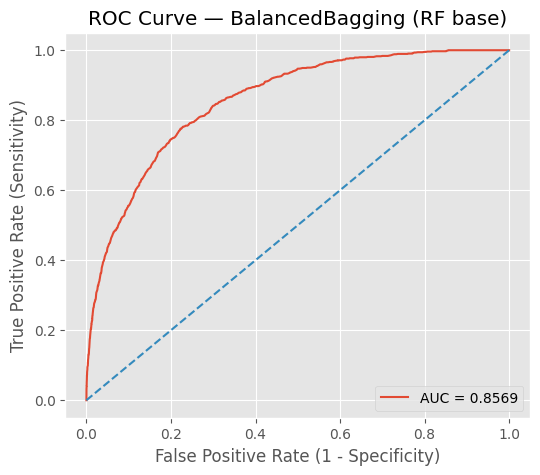

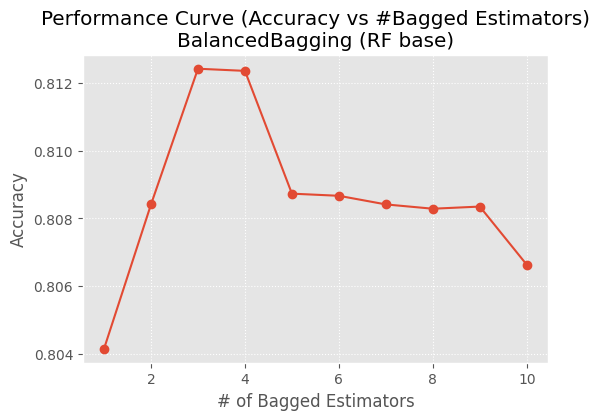

In [22]:
# Uses your existing train/test split variables
bb_model, bb_results = run_balanced_bagged_rf_with_tqdm(
    X_train, X_test, y_train, y_test,
    base_rf_trees=50,
    bag_estimators=10,
    bootstrap=True,
    replacement=False,
    random_state=42,
    n_jobs=-1,
    # base_rf_kwargs={"max_depth": None, "max_features": "sqrt"},
    # bag_kwargs={"oob_score": False},
    title="BalancedBagging (RF base)"
)


Fitting BalancedBagging (RF base):   0%|          | 0/40 [00:00<?, ?bag/s]


================ BENCHMARK ================
Model: BalancedBagging (RF base)
Loss (log loss):        0.4370511373307885
Accuracy:               0.809684
Precision:              0.218957
Sensitivity (Recall):   0.727969
Specificity (TNR):      0.815490
F1-score:               0.336656
ROC AUC:                0.8596397455665417
R-Square (regression):  N/A (classification)

Confusion Matrix:
 [[11982  2711]
 [  284   760]]


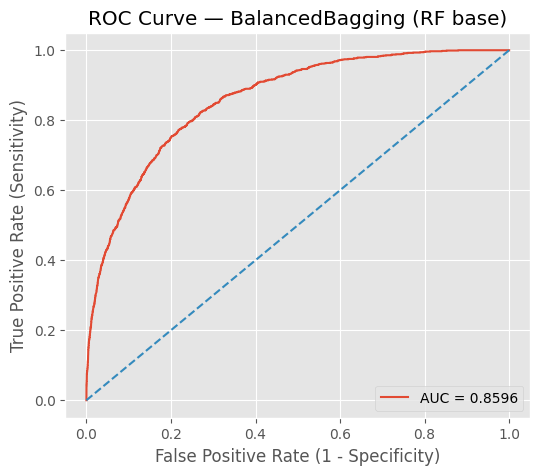

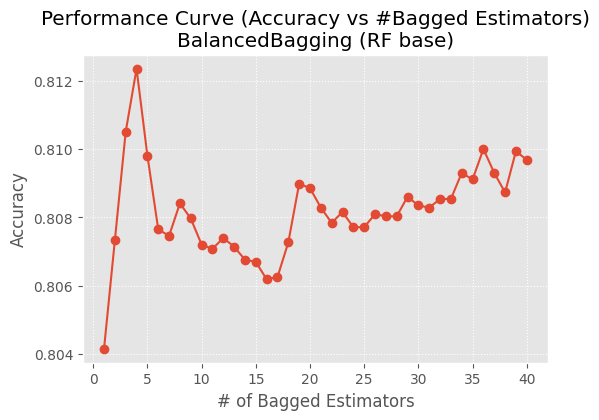

In [23]:
# Uses your existing train/test split variables
bb_model, bb_results = run_balanced_bagged_rf_with_tqdm(
    X_train, X_test, y_train, y_test,
    base_rf_trees=100,
    bag_estimators=40,
    bootstrap=True,
    replacement=False,
    random_state=42,
    n_jobs=-1,
    base_rf_kwargs={"max_depth": None, "max_features": "sqrt"},
    bag_kwargs={"oob_score": False},
    title="BalancedBagging (RF base)"
)
